In [7]:
import os#
#os.chdir('c:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH\\')
os.chdir("/rds/general/user/ma11115/home/STK_Search/STK_search")
from pathlib import Path#
import pandas as pd
import numpy as np
from stk_search.Objective_function import IP_ES1_fosc
from stk_search.utils import database_utils
import importlib

In [2]:
calculator = IP_ES1_fosc(oligomer_size =6)

In [112]:
# load the data and the precursors dataset
importlib.reload(database_utils)
df_total_path = 'data/output/Full_dataset/filtered_data150524.csv'
df_precursors_path ="data/output/Prescursor_data/precursor_data_new_clustering.pkl"
df_total , df_precursors= database_utils.load_data_from_file(df_total_path, df_precursors_path,add_feature_frag=True)
print(df_total.shape[0])

29589


In [32]:
df_precursors
def generate_list_monomer(df_precursors,oligomer_size = 6,):
    df_multi = pd.DataFrame()
    for i in range(oligomer_size):
        df_multi[f'InChIKey_{i}'] = df_precursors['InChIKey']

    return df_multi
df_elements = generate_list_monomer(df_precursors,oligomer_size = 6)

In [49]:
#split_df_elements to chunks and save them
def split_df_elements(df_elements,chunk_size = 10):
    n_chunks = int(np.ceil(df_elements.shape[0]/chunk_size))
    os.makedirs('data/dataframe_to_run_calculations',exist_ok = True)
    for i in range(n_chunks):
        df_elements.iloc[i*chunk_size:(i+1)*chunk_size].to_csv(f'data/dataframe_to_run_calculations/df_elements_{i+1}.csv',index = False)
    return n_chunks
num_iterations = split_df_elements(df_elements,chunk_size = 20)
print(num_iterations)

14


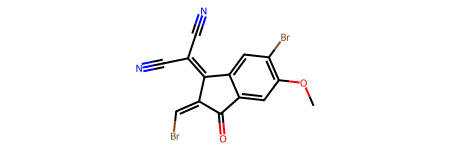

In [178]:
%matplotlib inline
df_precursors[df_precursors['InChIKey']=='MRBCQJMEGDDUNN-WMZJFQQLSA-N']['mol_opt_smiles'].iloc[0]

In [165]:
df_elements_1 = pd.read_csv('data/dataframe_to_run_calculations/df_elements_1.csv')
%run src/dev_scripts/Calculate_polymer_properties.py --df_path "data/dataframe_to_run_calculations/df_elements_1.csv" --oligomer_size 6

Fitness function: -1.9936456424839286 Inchikey: RVIGGSPUKFBKCN-UHFFFAOYSA-N


Fitness function: -3.763017903132753 Inchikey: FKDUEATUYXKRGK-OAZKBKIQSA-N
Error in InChIKey_0    PQZAHLJJGPAGBD-OQFOIZHKSA-N
InChIKey_1    PQZAHLJJGPAGBD-OQFOIZHKSA-N
InChIKey_2    PQZAHLJJGPAGBD-OQFOIZHKSA-N
InChIKey_3    PQZAHLJJGPAGBD-OQFOIZHKSA-N
InChIKey_4    PQZAHLJJGPAGBD-OQFOIZHKSA-N
InChIKey_5    PQZAHLJJGPAGBD-OQFOIZHKSA-N
Name: 2, dtype: object
Bad Conformer Id
Fitness function: -1.7252836757043173 Inchikey: NXUJZUWZLUEEKQ-UHFFFAOYSA-N
Fitness function: -2.90836136812444 Inchikey: BWRKKGMWJMOZNC-UHFFFAOYSA-N
Fitness function: -2.028016050536491 Inchikey: HJUSXTHOKGISNN-UHFFFAOYSA-N


KeyboardInterrupt: 

In [56]:
string_to_run = "python src/dev_scripts/Calculate_polymer_properties.py --df_path data/dataframe_to_run_calculations/df_elements_$PBS_ARRAY_INDEX.csv --oligomer_size 6"
script_qsub = "#!/bin/bash \n"+\
    "#PBS -l walltime=07:59:01 \n"+\
    f"#PBS -l select=1:ncpus={30}:mem={50}gb:avx=true \n"+\
    f"#PBS -J 1-{num_iterations} \n"+\
    " \n"+\
    "cd /rds/general/user/ma11115/home/STK_Search/STK_search \n"+\
    "module load anaconda3/personal \n"+ \
    "source activate Geom3D     \n"+\
    string_to_run
import datetime
def submit_job(script_qsub,):
    now = datetime.datetime.now()
    # print (now.strftime("%Y-%m-%d %H:%M:%S"))
    sh_file_name = (
        f"HPC_bash_script/runcalculations_{now.strftime('%M_%S_%f')}.sh"
    )
    with open(sh_file_name, "w") as text_file:
        text_file.write(script_qsub)

    os.system(f"qsub -e ./cache -o ./cache {sh_file_name}")
    return
submit_job(script_qsub,)

9431680[].pbs


## define a new benchmark dataframe

In [216]:
importlib.reload(database_utils)
df_total_new , df_precursors= database_utils.load_data_database(df_precursor_loc=df_precursors_path,num_fragm=6)
df_total_new.shape

/rds/general/user/ma11115/home/STK_Search/STK_search/src/stk_search/utils/database_utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f"InChIKey_{i}"] = df_test["BB"].apply(


(42629, 28)

In [218]:
df_total_new['InChIKey_list'] = list(np.vstack([df_total_new[f'InChIKey_{i}'] for i in range(6)]).T)
df_total_new['num_uniqu_BB'] = df_total_new['InChIKey_list'].apply(lambda x: len(set(x)))
df_total_new['num_uniqu_BB'].value_counts()

num_uniqu_BB
6    15005
4    12019
5     9254
3     5567
2      644
1      140
Name: count, dtype: int64

In [219]:
print(df_total.shape)
df_total_bench = pd.concat([df_total,df_total_new[df_total_new['num_uniqu_BB']==1]], ignore_index=True).reset_index(drop=True)
print(df_total_bench.shape)

(29589, 262)
(29729, 269)


In [220]:
df_to_add = df_total_new[~df_total_new['InChIKey'].isin(df_total_bench['InChIKey'])].sample(30000- df_total_bench.shape[0],random_state=42)
df_total_bench_final = pd.concat([df_total_bench,df_to_add]).reset_index(drop=True)

In [221]:
#drop columns from datafram
#df_total_bench_final = df_total_bench_final.select_dtypes(exclude=['object'])
df_total_bench_final = df_total_bench_final[list(df_total.columns[1:28])]
df_total_bench_final_path = 'data/output/Full_dataset/30K_benchmark_150524.csv'
df_total_bench_final.to_csv(df_total_bench_final_path,index = False)


/var/tmp/pbs.9430243.pbs/ipykernel_886361/4148390827.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_total_bench_final, x=f'num_uniqu_BB',y='target',ax=ax,palette='Set2',split=False, inner="point",density_norm="count")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-4.0, 1.0)

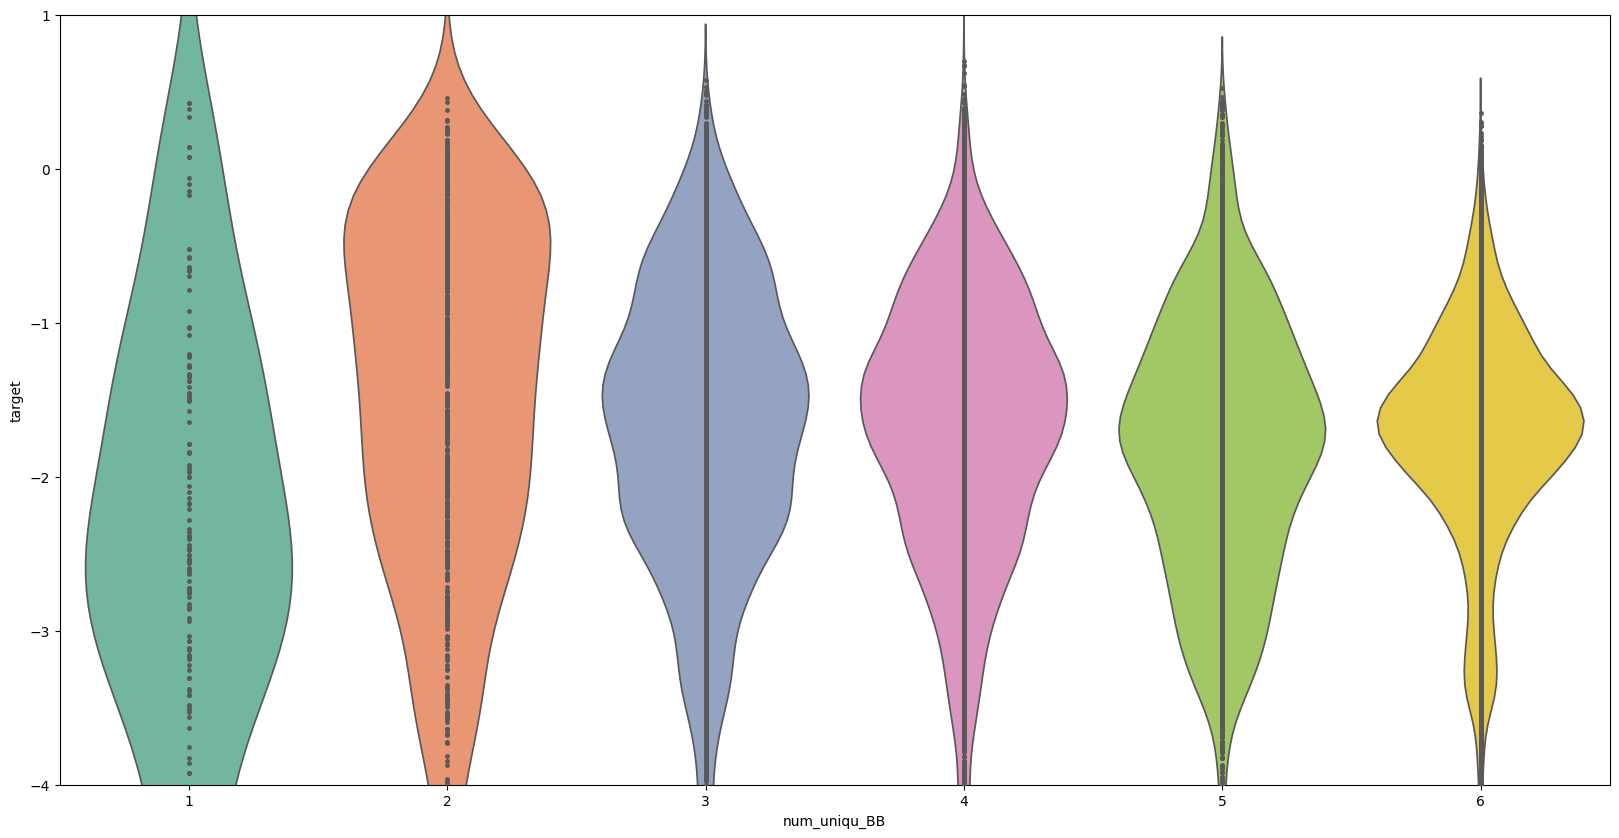

In [222]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(20,10))
df_total_bench_final['InChIKey_list'] = list(np.vstack([df_total_bench_final[f'InChIKey_{i}'] for i in range(6)]).T)
df_total_bench_final['num_uniqu_BB'] = df_total_bench_final['InChIKey_list'].apply(lambda x: len(set(x)))
sns.violinplot(data=df_total_bench_final, x=f'num_uniqu_BB',y='target',ax=ax,palette='Set2',split=False, inner="point",density_norm="count")
#sns.swarmplot(data=df_plot, x=f'num_uniqu_BB',y='target',ax=ax,color='k',size=3)#,split=False, inner="point",density_norm="area")
ax.legend().set_visible(False)
ax.set_ylim(-4,1)

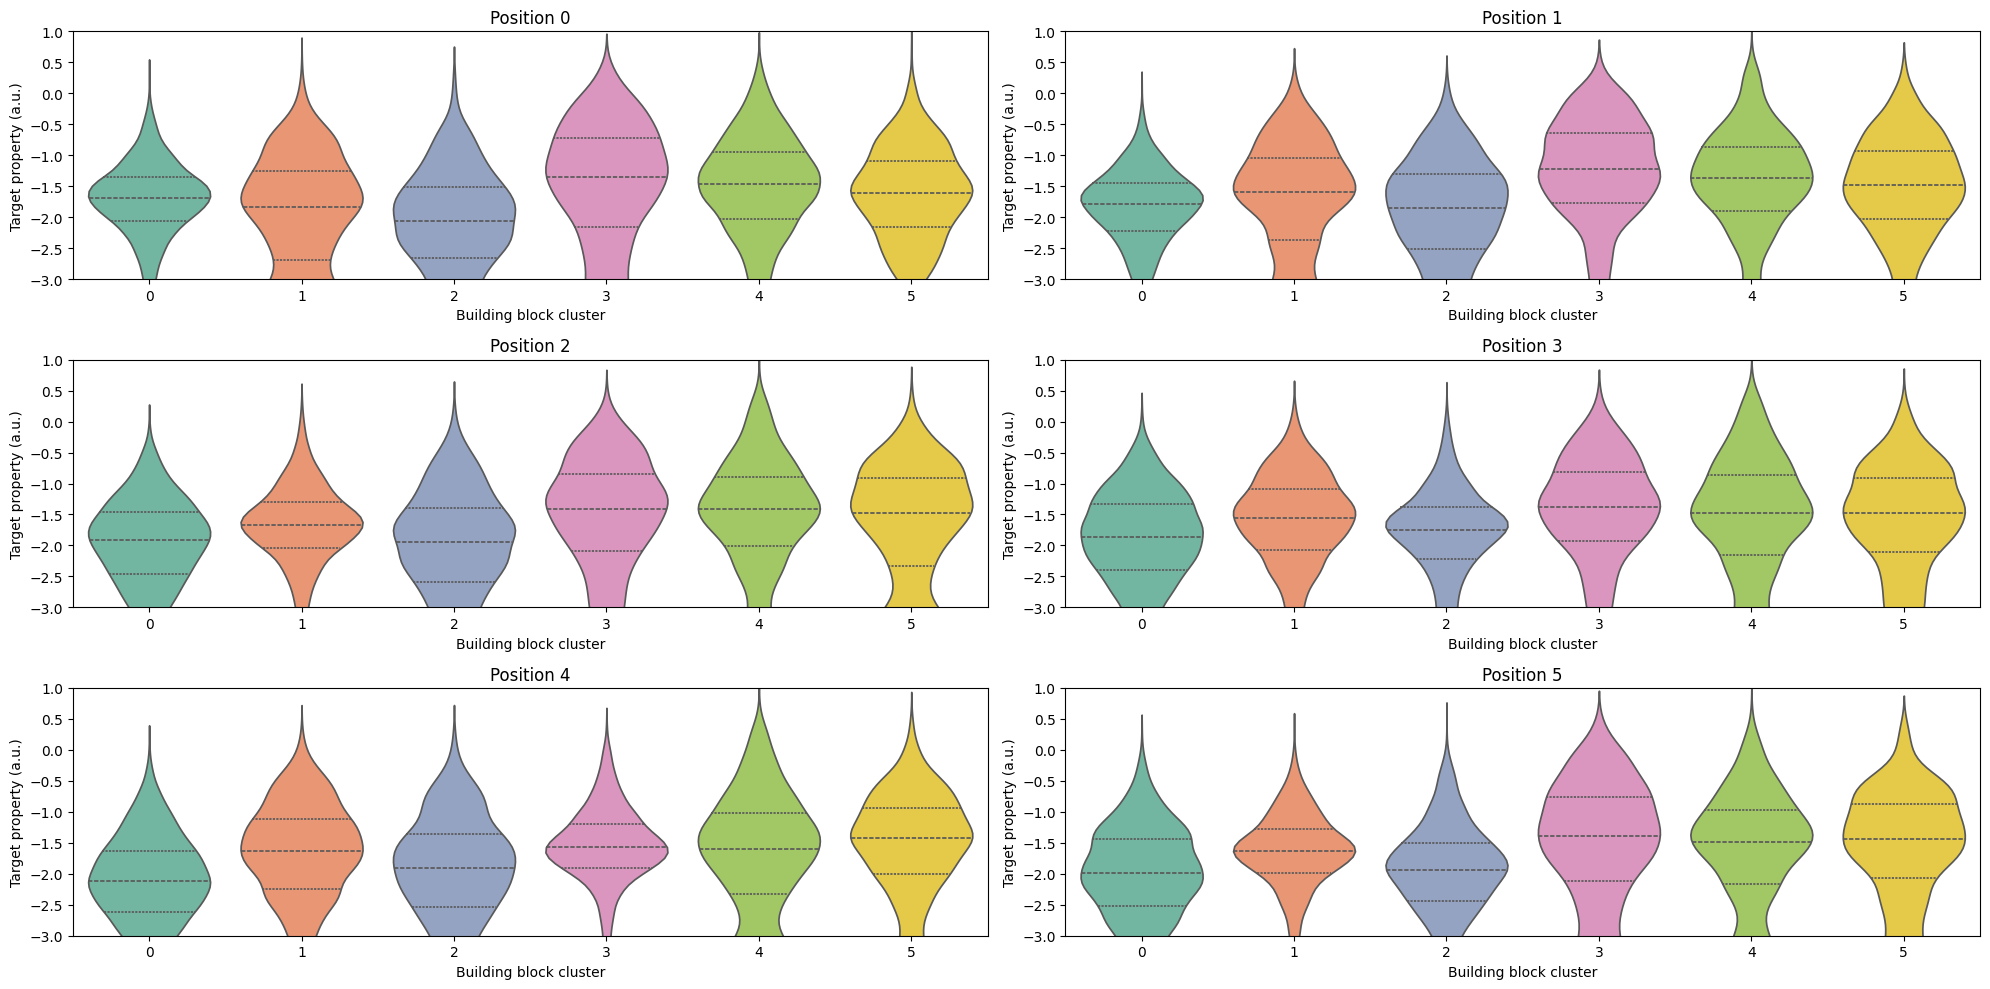

In [214]:
df_prec_cluster = df_precursors[['InChIKey','cluster']].copy()
df_prec_cluster['InChIKey_precursor'] = df_prec_cluster['InChIKey']
df_prec_cluster.drop('InChIKey',axis=1,inplace=True)
for i in range(6):
    df_total_bench_final['InChIKey_precursor'] = df_total_bench_final[f'InChIKey_{i}']
    df_total_bench_final = df_total_bench_final.merge(df_prec_cluster,how='left',on='InChIKey_precursor',suffixes=('',f'_{i}') )
    df_total_bench_final[f'cluster_{i}'] = df_total_bench_final['cluster']
    df_total_bench_final.drop('cluster',axis=1,inplace=True)
import seaborn as sns
fig,ax = plt.subplots(3,2,figsize=(20,10))
ax=ax.flatten()
for i,_ax in enumerate(ax[:6]):
    sns.violinplot(data=df_total_bench_final, x=f'cluster_{i}', y="target", split=False, inner="quart",ax=_ax,hue=f'cluster_{i}',palette='Set2')
    _ax.set_ylim(-3,1)
    _ax.legend().set_visible(False)
    _ax.set_title(f'Position {i}')
    _ax.set_xlabel(f'Building block cluster')
    _ax.set_ylabel(f'Target property (a.u.)')
fig.tight_layout()
import seaborn as sns

